In [1]:
import numpy as np
import pandas as pd
import os
import glob
import random
import shutil
import math

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("ticks")

import tifffile

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.transforms import functional as tvf
from torch.utils.data import DataLoader, Dataset

import torchsr

import timm
import timm.scheduler

import kornia
import kornia.augmentation as K
import kornia.utils

from torchmetrics import StructuralSimilarityIndexMeasure # ssim

from madgrad import MADGRAD

from tqdm.notebook import tqdm

from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

In [2]:
class CFG_set:
    EPOCHS = 3 ### 0 ~ 200
    # EPOCHS = 100 ### 201 ~ 300 / 301 ~ 400
    OPTIMIZER = "MADGRAD(net.parameters(),lr=2e-5/2,weight_decay=1e-6/2)" ### 0 ~ 200 / 201 ~ 300
    # OPTIMIZER = "MADGRAD(net.parameters(),lr=2e-5/3,weight_decay=1e-6/3)" ### 301 ~ 400

class CFG:
    # MODEL_NAME = "myRCAN"
    MODEL_NAME = "myRCAN_201_300"
    # MODEL_NAME = "myRCAN_301_400"
    VERSION = "0330"
    LOAD_PARAM = None
    # LOAD_PARAM = "myRCAN_0330" ### 201 ~ 300
    # LOAD_PARAM = "myRCAN_0330" ### 301 ^ 400
    DEVICE = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    N_FOLD = 5
    BATCH_SIZE = 4
    SEED = 0
    NUM_WORKERS = 32
    ROOT = "/root/workspace/solafune_SR"
    DATA_DIR = os.path.join(ROOT, "data") # 直下に /train & /test
    TRAIN_DIR = os.path.join(DATA_DIR, "train") # 直下に .tif *300
    TEST_DIR = os.path.join(DATA_DIR, "test") # # 直下に .tif * 300
    PARAM_DIR = os.path.join(ROOT, "net_params", f"{MODEL_NAME}_{VERSION}")

    SUBMISSION_TIF_DIR = os.path.join(ROOT, "submission_tif", f"{MODEL_NAME}_{VERSION}")

os.makedirs(CFG.PARAM_DIR, exist_ok=True)
os.makedirs(CFG.SUBMISSION_TIF_DIR, exist_ok=True)

print("=================================================")
print(f"MODEL_NAME : {CFG.MODEL_NAME} - VERSION : {CFG.VERSION}")
print(f"EPOCHS : {CFG_set.EPOCHS}   BATCH_SIZE : {CFG.BATCH_SIZE}")
print(f"ROOT : {CFG.ROOT}")
print(f"data_dir : {CFG.DATA_DIR}")
print(f"train_dir : {CFG.TRAIN_DIR}")
print(f"test_dir : {CFG.TEST_DIR}")
print(f"param_dir : {CFG.PARAM_DIR}")
print(f"submission_dir : {CFG.SUBMISSION_TIF_DIR}") ### .tif output
print("=================================================")

MODEL_NAME : myRCAN - VERSION : 0330
EPOCHS : 3   BATCH_SIZE : 4
ROOT : /root/workspace/solafune_SR
data_dir : /root/workspace/solafune_SR/data
train_dir : /root/workspace/solafune_SR/data/train
test_dir : /root/workspace/solafune_SR/data/test
param_dir : /root/workspace/solafune_SR/net_params/myRCAN_0330
submission_dir : /root/workspace/solafune_SR/submission_tif/myRCAN_0330


In [3]:
def get_df(train_dir, test_dir):
    train_filepath = os.path.join(train_dir, "*.tif") # low & high pair
    test_filepath = os.path.join(test_dir, "*.tif")

    train_low_pathlist = [ train_path for train_path in glob.glob(train_filepath) if train_path.find('low') != -1]
    train_high_pathlist = [ train_path for train_path in glob.glob(train_filepath) if train_path.find('high') != -1]

    train_low_pathlist = sorted(train_low_pathlist)
    train_high_pathlist = sorted(train_high_pathlist)
    test_pathlist = sorted(glob.glob(test_filepath))

    all_df = pd.DataFrame({
        "low_path": train_low_pathlist,
        "high_path":train_high_pathlist
    })

    test_df = pd.DataFrame({
        "test_path":test_pathlist
    })
    
    return all_df, test_df

def torch_seed(seed=0):
    """Fixed seed value."""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
torch_seed(CFG.SEED)

def visualize_process(train_loss_log, valid_loss_log, train_acc_log, valid_acc_log, title_="Acc"):
    """
    4params = def training 's return
    """
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_log, label="train")
    plt.plot(valid_loss_log, label="valid")
    plt.title("Loss_log")
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc_log, label="train")
    plt.plot(valid_acc_log, label="valid")
    plt.title(f"{title_}_log")
    plt.xlabel("epoch")
    plt.ylabel("score")
    plt.legend()
    plt.show()

    plt.clf()
    plt.close()

In [4]:
class HorizontalFlipTransform:
    def __init__(self):
        self.p = random.randint(0,1)

    def __call__(self, img_t:torch.tensor):
        if self.p == 1:
            return torchvision.transforms.functional.hflip(img_t)
        else:
            return img_t

class VerticalFlipTransform:
    def __init__(self):
        self.p = random.randint(0,1)

    def __call__(self, img_t:torch.tensor):
        if self.p == 1:
            return torchvision.transforms.functional.vflip(img_t)
        else:
            return img_t

class RotateTransform:
    def __init__(self):
        self.angle = random.choice([0,90,180,270])

    def __call__(self, img_t:torch.tensor):
        return torchvision.transforms.functional.rotate(img_t, self.angle)
    
class ChannelShuffle:
    def __init__(self):
        self.p = random.randint(0,1)
        self.order = random.sample([0,1,2], 3)

    def __call__(self, img_t:torch.tensor):
        if self.p == 1:
            img_t_s = img_t.clone()
            img_t_s[0], img_t_s[1], img_t_s[2] = img_t[self.order[0]], img_t[self.order[1]], img_t[self.order[2]]
            return img_t_s
        else:
            return img_t
        
class ColorJitter:
    def __init__(self):
        self.p = random.randint(0,1)

    def __call__(self, low_t, high_t):
        if self.p == 1:
            jitter = K.ColorJitter(0.1, 0.1, 0.1, 0.1, p=1., keepdim=True)
            low_t = jitter(low_t)
            high_t = jitter(high_t, jitter._params)
            return low_t, high_t
        else:
            return low_t, high_t

In [5]:
def load_path(net_, net_path, device_):
    net_.load_state_dict(torch.load(net_path, map_location=device_))
    return net_

class train_ImageTransform():
    def __init__(self):
        self.low_transform = transforms.Compose([
            transforms.ToTensor(),
            ])

        self.high_transform = transforms.Compose([
            transforms.ToTensor(),
            ])

    def __call__(self, low_img, high_img):
        low_t, high_t = self.low_transform(low_img), self.high_transform(high_img)
        ### 1 ~ 400
        Rotater = RotateTransform()
        low_t, high_t = Rotater(low_t), Rotater(high_t)
        H_flip = HorizontalFlipTransform()
        low_t, high_t = H_flip(low_t), H_flip(high_t)
        V_flip = VerticalFlipTransform()
        low_t, high_t = V_flip(low_t), V_flip(high_t)
        ### 1 ~ 201
        C_shuffle = ChannelShuffle()
        low_t, high_t = C_shuffle(low_t), C_shuffle(high_t)
        jitter = ColorJitter()
        low_t, high_t = jitter(low_t, high_t)
        return low_t, high_t

class valid_ImageTransform():
    def __init__(self):
        self.low_transform = transforms.Compose([
            transforms.ToTensor(),
            ])

        self.high_transform = transforms.Compose([
            transforms.ToTensor(),
            ])

    def __call__(self, low_img, high_img):
        low_t = self.low_transform(low_img)
        high_t = self.high_transform(high_img)
        return low_t, high_t
    
class sub_ImageTransform():
    def __init__(self):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            ])
    def __call__(self, img):
        return self.data_transform(img)

class ImageDataset(Dataset):
    def __init__(self, df, transform=None):
        super().__init__()
        self.df = df
        self.transform = transform 
    
    def __len__(self):
        return len(self.df) 

    def __getitem__(self, index):
        row = self.df.iloc[index]
        low_img_path = row.low_path
        high_img_path = row.high_path
        low_t, high_t = self.transform(tifffile.imread(low_img_path), tifffile.imread(high_img_path))
        return low_t, high_t

In [6]:
def RCAN_():
    net = torchsr.models.rcan(scale=4, pretrained=True)
    ### x4 -> x5
    m = list()
    conv1 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False)
    ps1 = nn.PixelShuffle(2)
    aap = nn.AdaptiveAvgPool2d((325,325))
    conv2 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False)
    ps2 = nn.PixelShuffle(2)
    conv_last = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=1, bias=False)
    m.append(conv1)
    m.append(ps1)
    m.append(aap)
    m.append(conv2)
    m.append(ps2)
    m.append(conv_last)
    tail_re = nn.Sequential(*m)
    for m in tail_re.modules():
        if isinstance(m, nn.Conv2d):
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, math.sqrt(2. / n))
            if m.bias is not None:
                m.bias.data.zero_()
    net.tail = tail_re
    return net

In [7]:
### training
def train_epoch(net, train_dataloader, ssim, optimizer, device):
    net.train()
    n_train = 0
    loss_total, ssim_total = 0,0
    for low_imgs, high_imgs in tqdm(train_dataloader):
        n_train += len(high_imgs)
        low_imgs, high_imgs = low_imgs.to(device, non_blocking=True), high_imgs.to(device, non_blocking=True)
        ssim.reset() # torch metrics
        optimizer.zero_grad()
        outputs = net(low_imgs)
        loss = 1 - ssim(outputs, high_imgs) # criterion with GPU
        loss.backward()
        optimizer.step()
        loss_total += loss.item()*len(high_imgs)
        ssim_total += (1-loss.item())*len(high_imgs) # ssim = 1 - train_loss
    return loss_total/n_train, ssim_total/n_train

### validation
def valid_epoch(net, valid_dataloader, ssim, device):
    net.eval()
    n_valid = 0
    loss_total, ssim_total = 0,0
    with torch.no_grad():
        for low_imgs, high_imgs in valid_dataloader:
            n_valid += len(high_imgs)
            low_imgs, high_imgs = low_imgs.to(device, non_blocking=True), high_imgs.to(device, non_blocking=True)
            ssim.reset() # torch metrics
            outputs = net(low_imgs)
            loss = 1 - ssim(outputs, high_imgs) # criterion with GPU
            loss_total += loss.item()*len(high_imgs)
            ssim_total += (1-loss.item())*len(high_imgs) # ssim = 1 - valid_loss
    return loss_total/n_valid, ssim_total/n_valid

### loop(training+validation)
def loop(cv, net, epochs, train_dataloader, valid_dataloader, scheduler, optimizer, device):
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device) # criterion with GPU
    torch.backends.cudnn.benchmark = True
    train_loss_log, train_ssim_log = list(), list()
    valid_loss_log, valid_ssim_log = list(), list()
    for epoch in range(epochs):
        train_loss, train_ssim = train_epoch(net, train_dataloader, ssim, optimizer, device)
        valid_loss, valid_ssim = valid_epoch(net, valid_dataloader, ssim, device)
        scheduler.step(epoch) # for timm

        train_loss_log.append(train_loss)
        train_ssim_log.append(train_ssim)
        valid_loss_log.append(valid_loss)
        valid_ssim_log.append(valid_ssim)

        print(f"Epoch [{epoch+1}/{epochs}], train_loss: {train_loss_log[epoch]:.5f}, train_ssim: {train_ssim_log[epoch]:.5f}", end=" ")
        print(f"valid_loss: {valid_loss_log[epoch]:.5f}, valid_ssim: {valid_ssim_log[epoch]:.5f}")

        ### save
        if np.argmax(valid_ssim_log) == epoch:
            torch.save(net.state_dict(), os.path.join(CFG.PARAM_DIR, f"ssim_cv{cv:02d}.pth"))

    return train_loss_log, train_ssim_log, valid_loss_log, valid_ssim_log

*************** fold:1 ***************


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [1/3], train_loss: 0.89951, train_ssim: 0.10049 valid_loss: 0.81853, valid_ssim: 0.18147


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [2/3], train_loss: 0.74778, train_ssim: 0.25222 valid_loss: 0.66550, valid_ssim: 0.33450


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [3/3], train_loss: 0.60545, train_ssim: 0.39455 valid_loss: 0.54776, valid_ssim: 0.45224


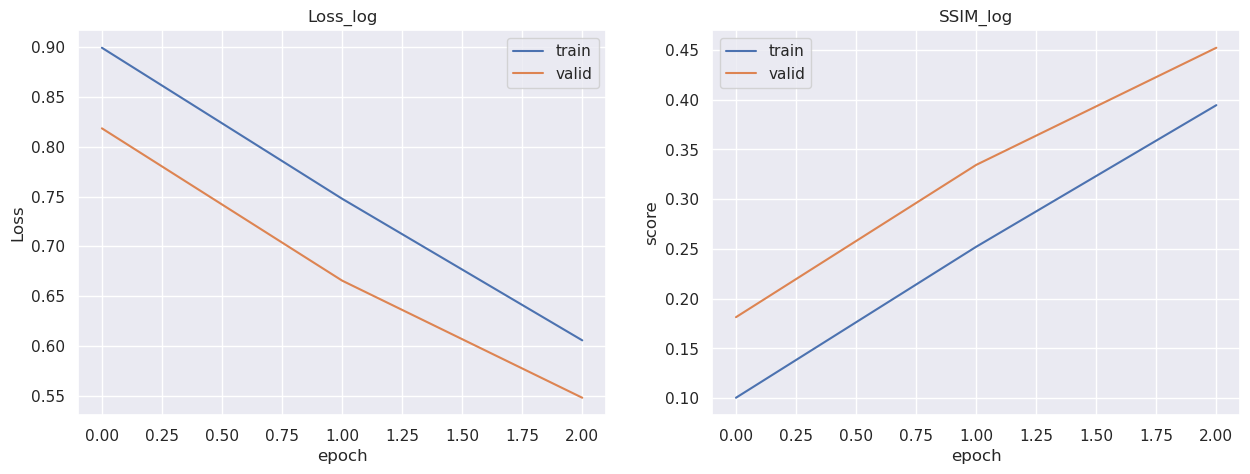

*************** fold:1 ***************
Epoch [3/3], train_loss: 0.60545, train_ssim: 0.39455 valid_loss: 0.54776, valid_ssim: 0.45224

*************** fold:2 ***************


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [1/3], train_loss: 0.86596, train_ssim: 0.13404 valid_loss: 0.77761, valid_ssim: 0.22239


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [2/3], train_loss: 0.69074, train_ssim: 0.30926 valid_loss: 0.59663, valid_ssim: 0.40337


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [3/3], train_loss: 0.56349, train_ssim: 0.43651 valid_loss: 0.51865, valid_ssim: 0.48135


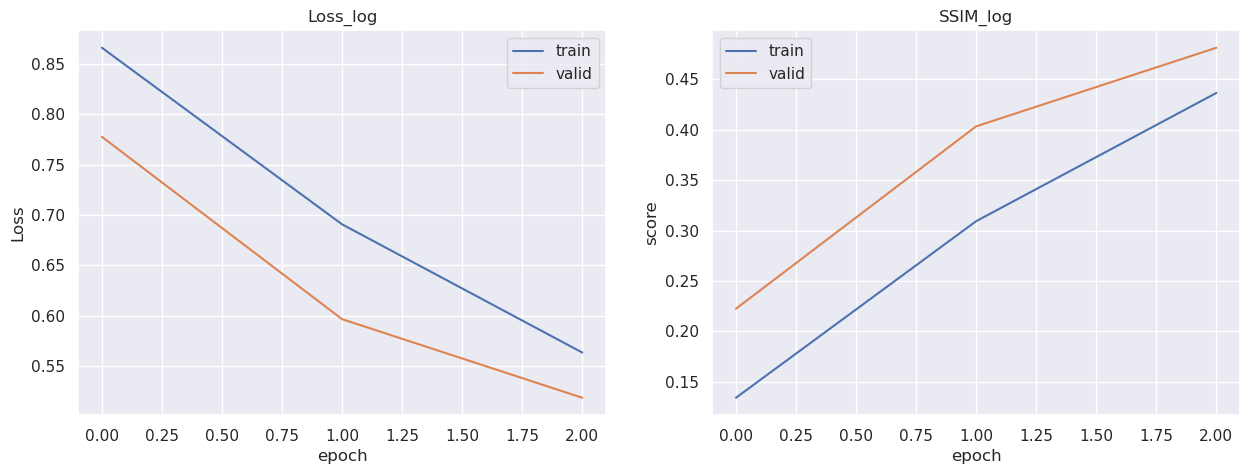

*************** fold:2 ***************
Epoch [3/3], train_loss: 0.56349, train_ssim: 0.43651 valid_loss: 0.51865, valid_ssim: 0.48135

*************** fold:3 ***************


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [1/3], train_loss: 0.87039, train_ssim: 0.12961 valid_loss: 0.78908, valid_ssim: 0.21092


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [2/3], train_loss: 0.69768, train_ssim: 0.30232 valid_loss: 0.59841, valid_ssim: 0.40159


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [3/3], train_loss: 0.56167, train_ssim: 0.43833 valid_loss: 0.53640, valid_ssim: 0.46360


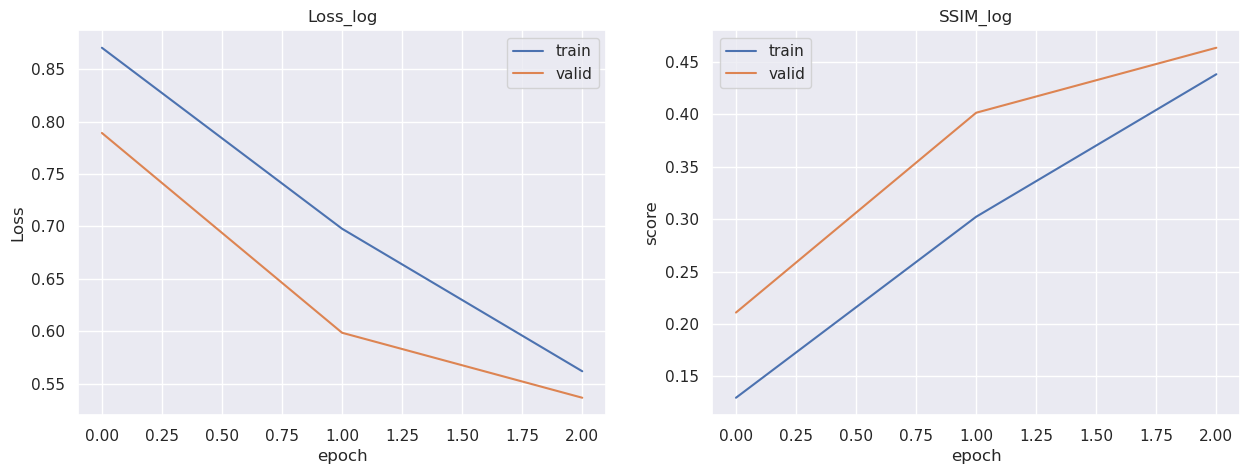

*************** fold:3 ***************
Epoch [3/3], train_loss: 0.56167, train_ssim: 0.43833 valid_loss: 0.53640, valid_ssim: 0.46360

*************** fold:4 ***************


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [1/3], train_loss: 0.88230, train_ssim: 0.11770 valid_loss: 0.79476, valid_ssim: 0.20524


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [2/3], train_loss: 0.70452, train_ssim: 0.29548 valid_loss: 0.61947, valid_ssim: 0.38053


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [3/3], train_loss: 0.57432, train_ssim: 0.42568 valid_loss: 0.52263, valid_ssim: 0.47737


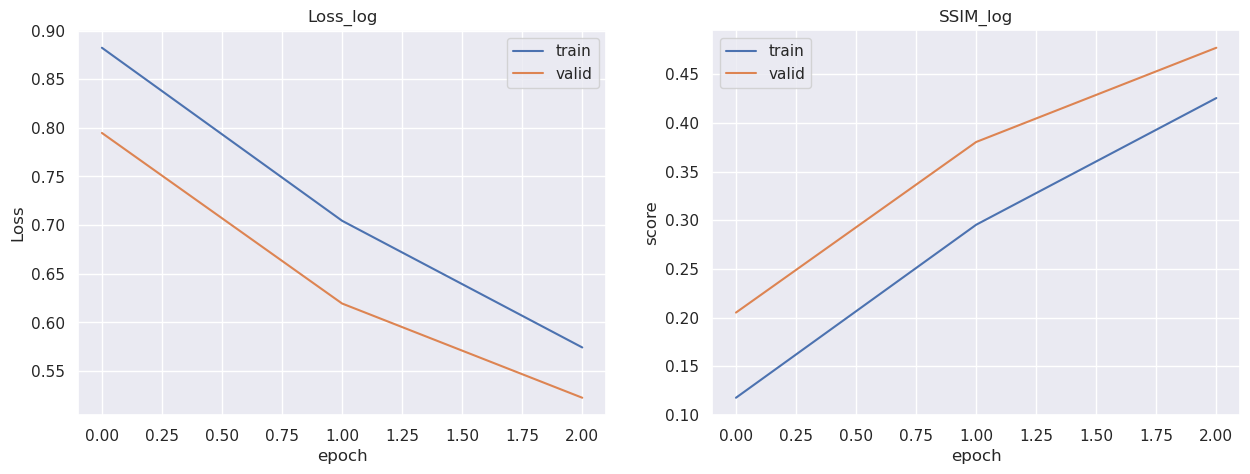

*************** fold:4 ***************
Epoch [3/3], train_loss: 0.57432, train_ssim: 0.42568 valid_loss: 0.52263, valid_ssim: 0.47737

*************** fold:5 ***************


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [1/3], train_loss: 0.88965, train_ssim: 0.11035 valid_loss: 0.81942, valid_ssim: 0.18058


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [2/3], train_loss: 0.70323, train_ssim: 0.29677 valid_loss: 0.61919, valid_ssim: 0.38081


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch [3/3], train_loss: 0.55397, train_ssim: 0.44603 valid_loss: 0.51616, valid_ssim: 0.48384


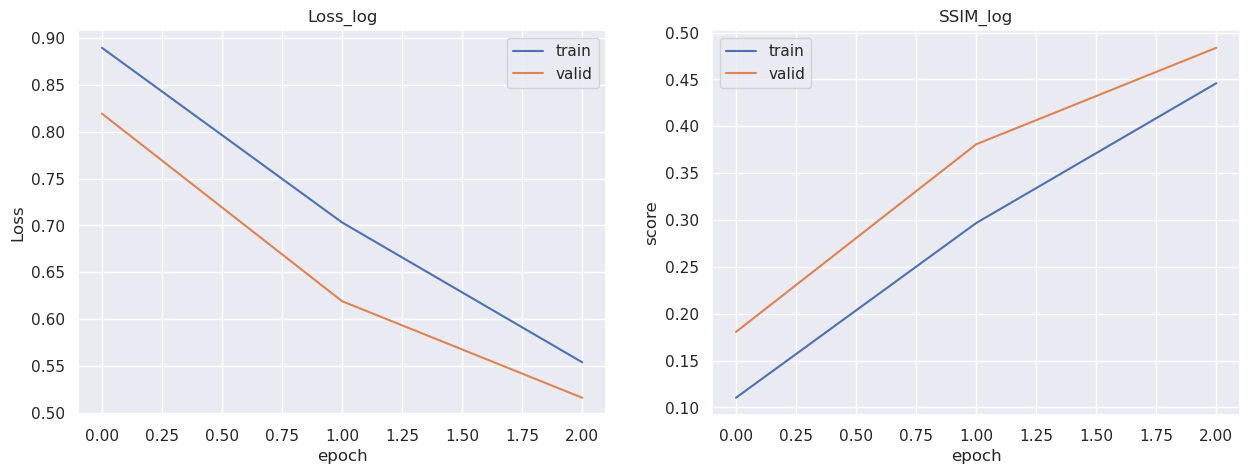

*************** fold:5 ***************
Epoch [3/3], train_loss: 0.55397, train_ssim: 0.44603 valid_loss: 0.51616, valid_ssim: 0.48384

param_dir : /root/workspace/solafune_SR/net_params/myRCAN_0330
['ssim_cv01.pth', 'ssim_cv02.pth', 'ssim_cv03.pth', 'ssim_cv04.pth', 'ssim_cv05.pth']


In [8]:
all_df, test_df = get_df(CFG.TRAIN_DIR, CFG.TEST_DIR) # (3000, 2) (400, 1)
all_df, test_df = all_df[:300], test_df[:100]
test_path_list = test_df["test_path"].tolist()

train_transform = train_ImageTransform()
valid_transform = valid_ImageTransform()
sub_transform = sub_ImageTransform()

device = CFG.DEVICE
torch.backends.cudnn.benchmark = True

kf = KFold(n_splits=CFG.N_FOLD, shuffle=True, random_state=CFG.SEED)
cv = 0

for train_index, valid_index in kf.split(all_df):
    net = RCAN_().to(CFG.DEVICE)
    cv +=1

    if CFG.LOAD_PARAM is not None:
        load_dir = os.path.join(CFG.PARAM_DIR, CFG.LOAD_PARAM)
        net_path = os.path.join(load_dir, f"ssim_cv{CFG.CV:02d}.pth")
        print(net_path)
        net = load_path(net, net_path, CFG.DEVICE)

    print(f"*************** fold:{cv} ***************")
    train_df, valid_df = all_df.iloc[train_index], all_df.iloc[valid_index]
    train_dataset = ImageDataset(train_df, transform=train_transform)
    valid_dataset = ImageDataset(valid_df, transform=valid_transform)
    train_dataloader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True, num_workers=CFG.NUM_WORKERS, pin_memory=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS, pin_memory=True)

    epochs = CFG_set.EPOCHS
    optimizer = eval(CFG_set.OPTIMIZER)

    ### tanh_scheduler / 1~200
    scheduler = timm.scheduler.TanhLRScheduler(optimizer, 
                                                    t_initial=epochs,
                                                    lr_min=1e-8,
                                                    t_in_epochs=True,
                                                    lb=-6, ub=4,
                                                    warmup_t = 30, warmup_lr_init=1e-8)

    ## Anealing_scheduler / 201 ~ 400
    # scheduler = timm.scheduler.CosineLRScheduler(optimizer,
    #                                                     t_initial=20,
    #                                                     lr_min=1e-8,
    #                                                     t_in_epochs=True,
    #                                                     cycle_limit=5,
    #                                                     cycle_decay=0.8,
    #                                                     cycle_mul=1.0)


    train_loss_log, train_ssim_log, valid_loss_log, valid_ssim_log = \
        loop(cv, net, epochs, train_dataloader, valid_dataloader, scheduler, optimizer, device)

    ##### result #####
    sns.set()
    visualize_process(train_loss_log, valid_loss_log, train_ssim_log, valid_ssim_log, title_="SSIM")

    print(f"*************** fold:{cv} ***************")
    best_ssim_ind = np.argmax(valid_ssim_log) # 0からカウント
    print(f"Epoch [{best_ssim_ind+1}/{epochs}], train_loss: {train_loss_log[best_ssim_ind]:.5f}, train_ssim: {train_ssim_log[best_ssim_ind]:.5f}", end=" ")
    print(f"valid_loss: {valid_loss_log[best_ssim_ind]:.5f}, valid_ssim: {valid_ssim_log[best_ssim_ind]:.5f}")
    print()

print(f"param_dir : {CFG.PARAM_DIR}")
print(sorted(os.listdir(CFG.PARAM_DIR)))

In [9]:
def get_phv_clipnp(test_path, clip_min=0, clip_max=1, rotate90 = False):
    """
    input : test_path
    output : output_0_np, output_h_np, output_v_np, output_hv_np
        dtype : float32 clip(clip_min, clip_max) 済みを返す
    rotate90 : True
        input_ = torchvision.transforms.functional.rotate(img_t, 90)
        後で -90 して戻す
    rotate90=False と rotate90=True の return 使えば 8パターン
    """
    input_ = tifffile.imread(test_path) # numpy (130, 130, 3)
    input_ = sub_transform(input_) # torch.Size([3, 130, 130])
    ### rotate90
    if rotate90:
        input_ = torchvision.transforms.functional.rotate(input_, 90)
    ### 回転なし
    input_0 = input_.unsqueeze(0).to(CFG.DEVICE) # torch.Size([1, 3, 130, 130])
    output_0 = net(input_0) # torch.Size([1, 3, 650, 650]) / torch.float32 / マイナスもある
    output_0 = output_0.squeeze()
    ### hflip
    input_h = tvf.hflip(input_)
    input_h = input_h.unsqueeze(0).to(CFG.DEVICE)
    output_h = net(input_h)
    output_h = output_h.squeeze() ### hflip
    output_h = tvf.hflip(output_h) ### hfilpを戻す
    ### vflip
    input_v = tvf.vflip(input_)
    input_v = input_v.unsqueeze(0).to(CFG.DEVICE)
    output_v = net(input_v)
    output_v = output_v.squeeze() ### vflip
    output_v = tvf.vflip(output_v) ### vfilpを戻す
    ### hflip + vflip
    input_h = tvf.hflip(input_)
    input_hv = tvf.vflip(input_h)
    input_hv = input_hv.unsqueeze(0).to(CFG.DEVICE)
    output_hv = net(input_hv)
    output_hv = output_hv.squeeze() ### hvflip
    output_hv = tvf.vflip(output_hv) ### vfilpを戻す
    output_hv = tvf.hflip(output_hv) ### hflipを戻す
    ### rotate90戻す
    if rotate90:
        output_0 = tvf.rotate(output_0, -90)
        output_h = tvf.rotate(output_h, -90)
        output_v = tvf.rotate(output_v, -90)
        output_hv = tvf.rotate(output_hv, -90)
    ### to_numpy
    output_0_np = output_0.cpu().detach().numpy().transpose((1,2,0)) # numpy (650, 650, 3) / float32 / マイナスもある
    output_0_np = np.clip(output_0_np, clip_min, clip_max) ### uint8 にする前にclipしとく
    output_h_np = output_h.cpu().detach().numpy().transpose((1,2,0)) 
    output_h_np = np.clip(output_h_np, clip_min, clip_max)
    output_v_np = output_v.cpu().detach().numpy().transpose((1,2,0)) 
    output_v_np = np.clip(output_v_np, clip_min, clip_max)
    output_hv_np = output_hv.cpu().detach().numpy().transpose((1,2,0)) 
    output_hv_np = np.clip(output_hv_np, clip_min, clip_max)
    return output_0_np, output_h_np, output_v_np, output_hv_np

In [10]:
def make_zip(net, net_path_list, N_FOLD=5):
    evok = 0 ### 許容値
    clip_min, clip_max = 0-evok, 1+evok

    for test_path in test_path_list:
        pred_np = 0 # N_FOLD の数だけ予測したnpを積んでいく
        for net_path in net_path_list:
            net = load_path(net, net_path, CFG.DEVICE)
            net.eval()
            output_0_np, output_h_np, output_v_np, output_hv_np = get_phv_clipnp(test_path, clip_min=clip_min, clip_max=clip_max, rotate90 = False)
            output_0_np90, output_h_np90, output_v_np90, output_hv_np90 = get_phv_clipnp(test_path, clip_min=clip_min, clip_max=clip_max, rotate90 = True)
            output_bind = (output_0_np + output_h_np + output_v_np + output_hv_np + output_0_np90 + output_h_np90 + output_v_np90 + output_hv_np90)/8
            pred_np += output_bind
        pred_np /= N_FOLD
        ### get_phv_clipnp で clip 幅を少し広めにするのであれば、ここでもう一回 bind を clip
        pred_np = np.clip(pred_np, 0, 1)
        pred_np = pred_np*255
        pred_np = np.round(pred_np)
        pred_np = pred_np.astype("uint8") # 画像を1枚に確定
        ### 書き出し
        filename = test_path.split("/")[-1]
        sub_filename = filename.replace("low", "answer")
        tifffile.imwrite(os.path.join(CFG.SUBMISSION_TIF_DIR, sub_filename), pred_np, photometric='rgb')

    ### 圧縮したいフォルダのパス
    base_ = CFG.SUBMISSION_TIF_DIR
    shutil.make_archive(f"{base_}_TTA", format='zip', root_dir=base_)
    print(f"output_zip : {base_}_TTA.zip")

In [11]:
net = RCAN_().to(CFG.DEVICE)
# test_path_list = test_df["test_path"].tolist()
test_path_list = test_df["test_path"].tolist()[0:10]
net_path_list = [os.path.join(CFG.PARAM_DIR, f"ssim_cv{cv:02d}.pth") for cv in range(1,CFG.N_FOLD+1)]
print(net_path_list)
sub_transform = sub_ImageTransform()

make_zip(net, net_path_list)

['/root/workspace/solafune_SR/net_params/myRCAN_0330/ssim_cv01.pth', '/root/workspace/solafune_SR/net_params/myRCAN_0330/ssim_cv02.pth', '/root/workspace/solafune_SR/net_params/myRCAN_0330/ssim_cv03.pth', '/root/workspace/solafune_SR/net_params/myRCAN_0330/ssim_cv04.pth', '/root/workspace/solafune_SR/net_params/myRCAN_0330/ssim_cv05.pth']
output_zip : /root/workspace/solafune_SR/submission_tif/myRCAN_0330_TTA.zip
